In [22]:
import tensorflow as tf
import tensorflow.keras
import numpy as np
import matplotlib.pyplot as plt

In [7]:
dataset=tf.keras.preprocessing.image_dataset_from_directory('/content/drive/MyDrive/DeepLearning/Leaf_disease_Classification/Datasets',
                                                            shuffle=True,
                                                            image_size=(224,224),
                                                            batch_size=16)

Found 239 files belonging to 5 classes.


In [3]:
class_names=dataset.class_names
class_names

['Bacteria', 'Fungi', 'Nematodes', 'Normal', 'Virus']

In [16]:
def get_partitions(dataset, train_split=0.90, val_split=0.10, shuffle=True,shuffle_size=10000):
  dataset_size=len(dataset)
  train_size=int(train_split*dataset_size)
  val_size=int(val_split*dataset_size)

  train=dataset.take(train_size)
  left=dataset.skip(train_size)
  val=left.take(val_size)
  test=left.skip(val_size)

  return train,val,test

In [17]:
train,val,test=get_partitions(dataset)

In [21]:
len(train),len(val),len(test)

(13, 1, 1)

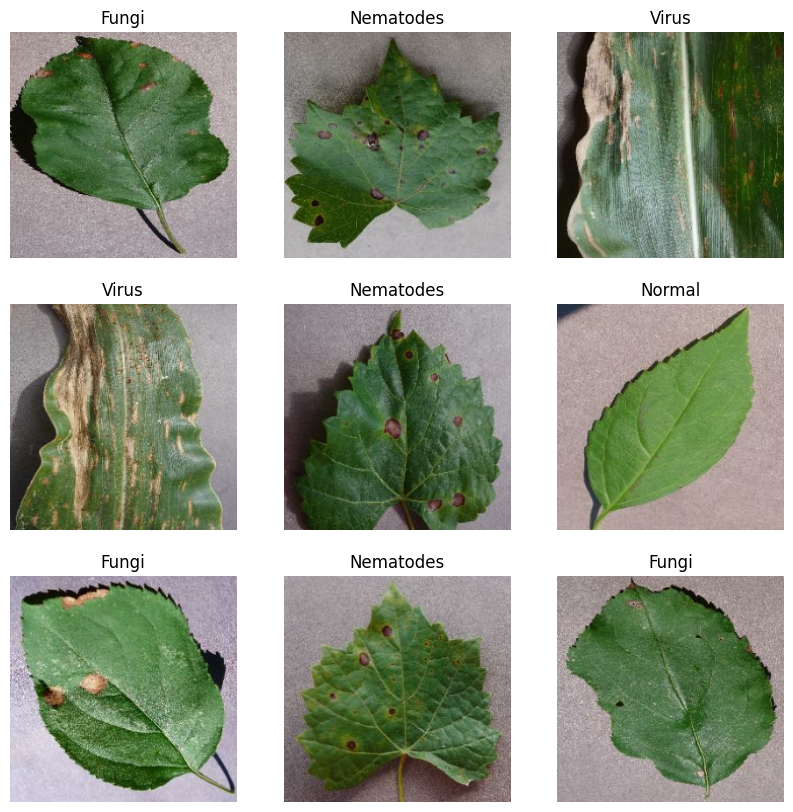

In [27]:
plt.figure(figsize=(10,10))

for image,labels in train.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [29]:
train=train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val=val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test=test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [33]:
from tensorflow import keras
from keras.layers import Conv2D,Dropout, MaxPooling2D, Resizing, Rescaling, RandomFlip, RandomRotation, RandomZoom, Dense, Flatten

In [35]:
model= keras.Sequential()

model.add(Resizing(224,224))
model.add(Rescaling(1.0/255))

model.add(RandomFlip('horizontal_and_vertical', input_shape=(16,224,224,3)))
model.add(RandomRotation(0.2))
model.add(RandomZoom(0.2))

model.add(Conv2D(32,3,padding='same',activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64,3,padding='same',activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128,3,padding='same',activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(len(class_names), activation='softmax'))


In [45]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [46]:
model.build(input_shape=(16,224,224,3))

In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_1 (RandomR  (None, 224, 224, 3)       0         
 otation)                                                        
                                                                 
 random_zoom_1 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      896       
                                                      

In [49]:
history=model.fit(train,epochs=100,batch_size=16, verbose=1, validation_data=val)

Epoch 1/100
13/13 [==============================] - 1s 50ms/step - loss: 0.1565 - accuracy: 0.9567 - val_loss: 0.0826 - val_accuracy: 1.0000
Epoch 2/100
13/13 [==============================] - 1s 47ms/step - loss: 0.1342 - accuracy: 0.9663 - val_loss: 0.0335 - val_accuracy: 1.0000
Epoch 3/100
13/13 [==============================] - 1s 47ms/step - loss: 0.3369 - accuracy: 0.8846 - val_loss: 0.2745 - val_accuracy: 0.8750
Epoch 4/100
13/13 [==============================] - 1s 46ms/step - loss: 0.2562 - accuracy: 0.9231 - val_loss: 0.0963 - val_accuracy: 0.9375
Epoch 5/100
13/13 [==============================] - 1s 46ms/step - loss: 0.2790 - accuracy: 0.9038 - val_loss: 0.0819 - val_accuracy: 1.0000
Epoch 6/100
13/13 [==============================] - 1s 46ms/step - loss: 0.2346 - accuracy: 0.9375 - val_loss: 0.0950 - val_accuracy: 1.0000
Epoch 7/100
13/13 [==============================] - 1s 46ms/step - loss: 0.2221 - accuracy: 0.9135 - val_loss: 0.1750 - val_accuracy: 0.8750
Epoch 

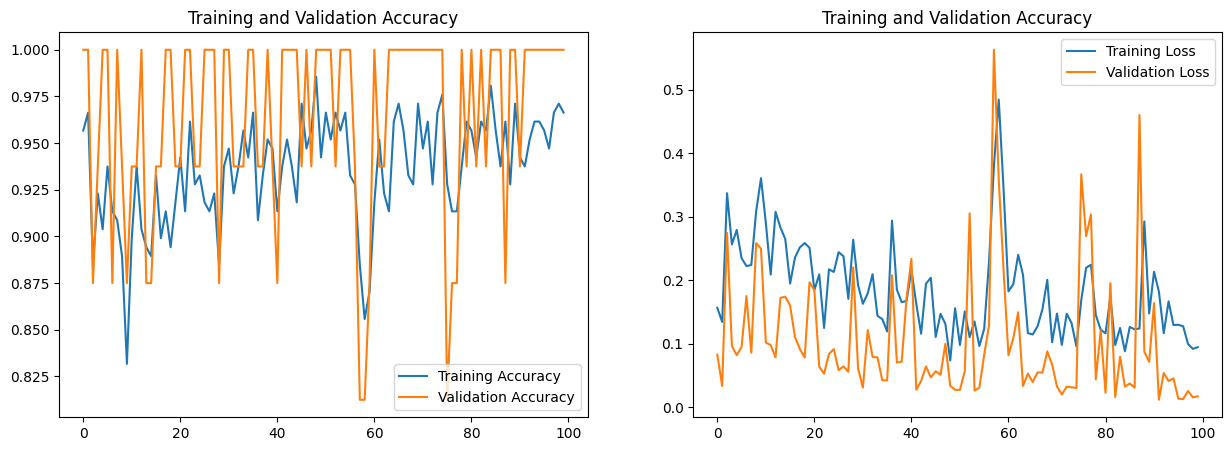

In [62]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(100)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc,label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Training Loss')
plt.plot(epochs_range,val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')
plt.show()

In [63]:
score=model.evaluate(test)

1/1 [==============================] - 1s 1s/step - loss: 0.0173 - accuracy: 1.0000


In [71]:
def prediction(model, image):
  img_array=tf.keras.preprocessing.image.img_to_array(image.numpy())
  img_array=tf.expand_dims(img_array,0)

  prediction=model.predict(img_array)

  predicted_class=class_names[np.argmax(prediction[0])]
  confidence=round(100*np.max(prediction[0]))

  return predicted_class,confidence

In [72]:
plt.figure(figsize=(15, 15))
for images, labels in test.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = prediction(model, images[i])
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.